In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

df_train= pd.read_csv('train.csv')
df_train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


# Baseline model Random Forest Regressor

In [3]:
df_train_baseline= df_train.copy()

In [4]:
df_train_baseline = df_train_baseline.drop(columns=['id'])

# Fill missing categorical values with 'Unknown'
categorical_cols = df_train_baseline.select_dtypes(include='object').columns
df_train_baseline[categorical_cols] = df_train_baseline[categorical_cols].fillna('Unknown')

# Encode categorical features using Label Encoding
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_train_baseline[col] = le.fit_transform(df_train_baseline[col])
    label_encoders[col] = le

# Split into features and target
X = df_train_baseline.drop(columns=['price'])
y = df_train_baseline['price']

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)

rmse

75255.62684538394

# Preprocessing steps

In [5]:
import re

# Make a copy
df_cleaned = df_train.copy()

# Drop 'id' and 'model'
df_cleaned.drop(columns=['id', 'model'], inplace=True, errors='ignore')  # use errors='ignore' in case 'id' is missing

# Extract features from 'engine'
def extract_engine_features(engine_str):
    if isinstance(engine_str, str):
        hp_match = re.search(r'([\d.]+)\s*HP', engine_str)
        liter_match = re.search(r'([\d.]+)L', engine_str)
        cyl_match = re.search(r'(\d+)\s*Cyl', engine_str)
        fuel_match = re.search(r'(Gasoline|Flex Fuel|Diesel|Hybrid|Electric|CNG)', engine_str, re.IGNORECASE)

        return pd.Series({
            'engine_hp': float(hp_match.group(1)) if hp_match else None,
            'engine_liter': float(liter_match.group(1)) if liter_match else None,
            'engine_cyl': int(cyl_match.group(1)) if cyl_match else None,
            'engine_fuel_extracted': fuel_match.group(1).capitalize() if fuel_match else 'Unknown'
        })
    else:
        return pd.Series({'engine_hp': None, 'engine_liter': None, 'engine_cyl': None, 'engine_fuel_extracted': 'Unknown'})

# Apply to engine column
engine_features = df_cleaned['engine'].apply(extract_engine_features)
df_cleaned = pd.concat([df_cleaned, engine_features], axis=1)

# Drop original 'engine' column
df_cleaned.drop(columns=['engine'], inplace=True)

In [6]:
df_cleaned

,brand,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,engine_hp,engine_liter,engine_cyl,engine_fuel_extracted
0,MINI,2007,213000,Gasoline,A/T,Yellow,Gray,None reported,Yes,4200,172.0,1.6,4.0,Gasoline
1,Lincoln,2002,143250,Gasoline,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,252.0,3.9,8.0,Gasoline
2,Chevrolet,2002,136731,E85 Flex Fuel,A/T,Blue,Gray,None reported,Yes,13900,320.0,5.3,8.0,Flex fuel
3,Genesis,2017,19500,Gasoline,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,420.0,5.0,8.0,Gasoline
4,Mercedes-Benz,2021,7388,Gasoline,7-Speed A/T,Black,Beige,None reported,Yes,97500,208.0,2.0,4.0,Gasoline
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,Cadillac,2017,49000,Gasoline,Transmission w/Dual Shift Mode,White,Beige,None reported,Yes,27500,420.0,6.2,8.0,Gasoline
188529,Mercedes-Benz,2018,28600,Gasoline,8-Speed A/T,White,Black,At least 1 accident or damage reported,Yes,30000,385.0,3.0,6.0,Gasoline
188530,Mercedes-Benz,2021,13650,Gasoline,7-Speed A/T,White,Black,None reported,Yes,86900,469.0,4.0,8.0,Gasoline
188531,Audi,2022,13895,Gasoline,1-Speed Automatic,Daytona Gray Pearl Effect,Black,None reported,NaN,84900,NaN,3.0,NaN,Unknown


In [7]:
# Fill missing fuel_type with engine_fuel_extracted
df_cleaned['fuel_type'] = df_cleaned['fuel_type'].fillna(df_cleaned['engine_fuel_extracted'])

# Drop the extracted column
df_cleaned.drop(columns=['engine_fuel_extracted'], inplace=True)

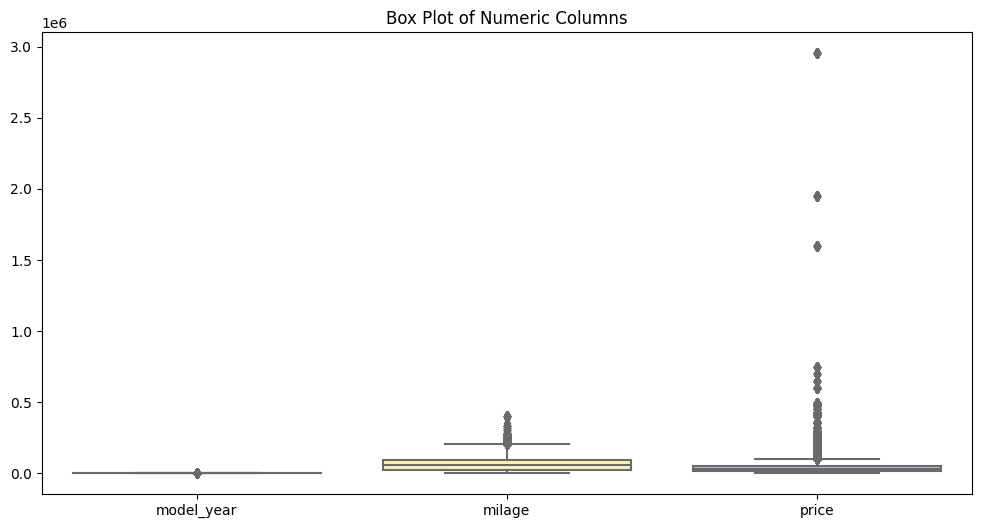

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create box plots to detect outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_cleaned[['model_year', 'milage', 'price']], palette="Set3")
plt.title('Box Plot of Numeric Columns')
plt.show()

In [9]:
df_cleaned.drop(columns=['id', 'clean_title'], inplace=True, errors='ignore')


In [10]:
# Check for missing values in all columns
missing_summary = df_cleaned.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)

print("Missing values per column:")
print(missing_summary)


Missing values per column:
engine_cyl      37855
engine_hp       33259
engine_liter    14214
accident         2452
dtype: int64


In [11]:
df_cleaned['accident'] = df_cleaned['accident'].fillna('None reported')

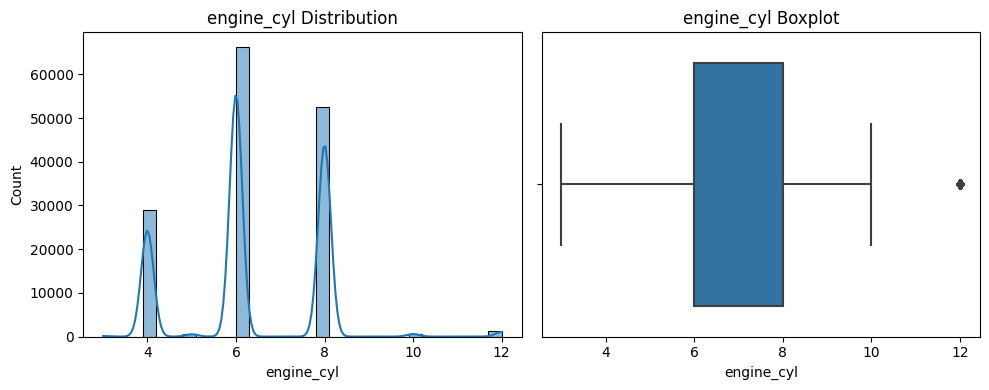

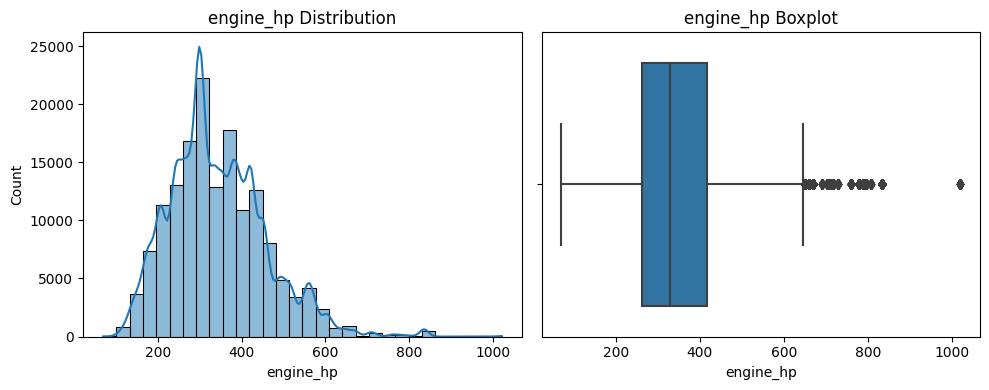

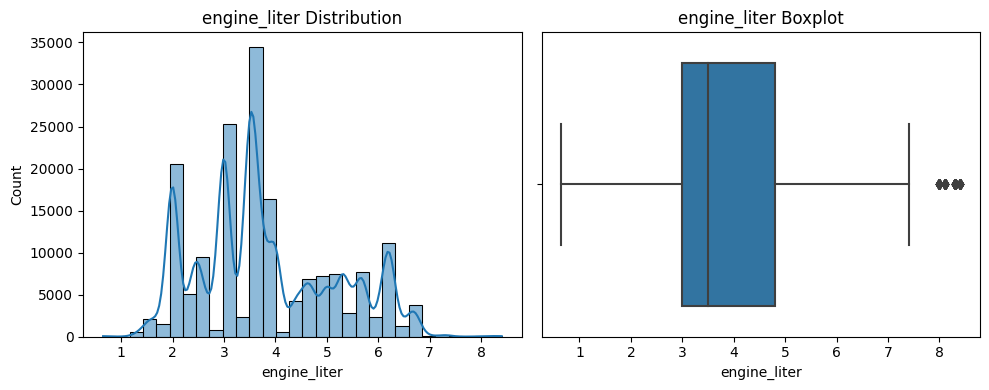

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

cols = ['engine_cyl', 'engine_hp', 'engine_liter']

for col in cols:
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(df_cleaned[col], kde=True, bins=30)
    plt.title(f'{col} Distribution')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_cleaned[col])
    plt.title(f'{col} Boxplot')

    plt.tight_layout()
    plt.show()


In [13]:
df_cleaned['engine_cyl'] = df_cleaned['engine_cyl'].fillna(df_cleaned['engine_cyl'].median())
df_cleaned['engine_hp'] = df_cleaned['engine_hp'].fillna(df_cleaned['engine_hp'].median())
df_cleaned['engine_liter'] = df_cleaned['engine_liter'].fillna(df_cleaned['engine_liter'].median())

engine_cyl: Median is preferred because most cars have standard cylinder counts (like 4, 6, or 8), while luxury or rare models introduce outliers.

engine_hp: Median is used since most vehicles fall within common horsepower ranges, but luxury or performance cars skew the distribution with high outliers.

engine_liter: Median is chosen due to distinct peaks at typical engine sizes (e.g., 2.0L, 3.5L), while larger luxury engines create a right-skewed distribution.

In [14]:
# Remove extreme outliers
df_filtered = df_cleaned[
    (df_cleaned['engine_hp'] < 600) &
    (df_cleaned['engine_liter'] < 6) &
    (df_cleaned['engine_cyl'] <= 8)
]

# Remove very old cars
df_filtered = df_filtered[df_filtered['model_year'] >= 2005]


In [15]:
# Define reasonable thresholds
milage_limit = 150000
price_limit = 100000

# Filter out extreme mileage and price
df_cleaned = df_filtered[
    (df_filtered['milage'] <= milage_limit) &
    (df_filtered['price'] <= price_limit)
]


In [16]:
df_cleaned.describe(include='all')

,brand,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,price,engine_hp,engine_liter,engine_cyl
count,139789,139789.000000,139789.00000,139789,139789,139789,139789,139789,139789.000000,139789.000000,139789.000000,139789.000000
unique,55,NaN,NaN,10,52,318,156,2,NaN,NaN,NaN,NaN
top,Ford,NaN,NaN,Gasoline,A/T,Black,Black,None reported,NaN,NaN,NaN,NaN
freq,16494,NaN,NaN,125194,34914,36452,82856,110312,NaN,NaN,NaN,NaN
mean,NaN,2016.667406,59457.80007,NaN,NaN,NaN,NaN,NaN,34681.700656,327.948208,3.439870,6.032070
std,NaN,4.390998,38298.49704,NaN,NaN,NaN,NaN,NaN,20550.506768,86.606160,1.043408,1.239317
min,NaN,2005.000000,100.00000,NaN,NaN,NaN,NaN,NaN,2000.000000,76.000000,0.650000,3.000000
25%,NaN,2014.000000,26000.00000,NaN,NaN,NaN,NaN,NaN,18750.000000,278.000000,2.900000,6.000000
50%,NaN,2018.000000,55564.00000,NaN,NaN,NaN,NaN,NaN,30500.000000,329.000000,3.500000,6.000000
75%,NaN,2020.000000,87500.00000,NaN,NaN,NaN,NaN,NaN,45900.000000,375.000000,3.800000,6.000000


In [17]:
df_cleaned.shape

(139789, 12)

In [18]:
# Check for any missing values in the entire DataFrame
total_missing = df_cleaned.isnull().sum().sum()

if total_missing == 0:
    print("✅ No missing values in the dataset.")
else:
    print(f"⚠️ There are {total_missing} missing values remaining.")


✅ No missing values in the dataset.


In [19]:
from sklearn.preprocessing import LabelEncoder

# Identify object columns
object_cols = df_filtered.select_dtypes(include='object').columns.tolist()
print("Categorical columns to encode:", object_cols)

# Apply Label Encoding to each object column
label_encoders = {}

for col in object_cols:
    le = LabelEncoder()
    df_filtered[col] = le.fit_transform(df_filtered[col].astype(str))  # force to string just in case
    label_encoders[col] = le


Categorical columns to encode: ['brand', 'fuel_type', 'transmission', 'ext_col', 'int_col', 'accident']


In [20]:
from sklearn.model_selection import train_test_split

X = df_filtered.drop(columns=['price'])
y = df_filtered['price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Lighter model
rf_model = RandomForestRegressor(
    n_estimators=20,
    max_depth=10,
    random_state=42,
    n_jobs=1
)

# Train and evaluate
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print("RMSE:", rmse)

RMSE: 63635.616012225706


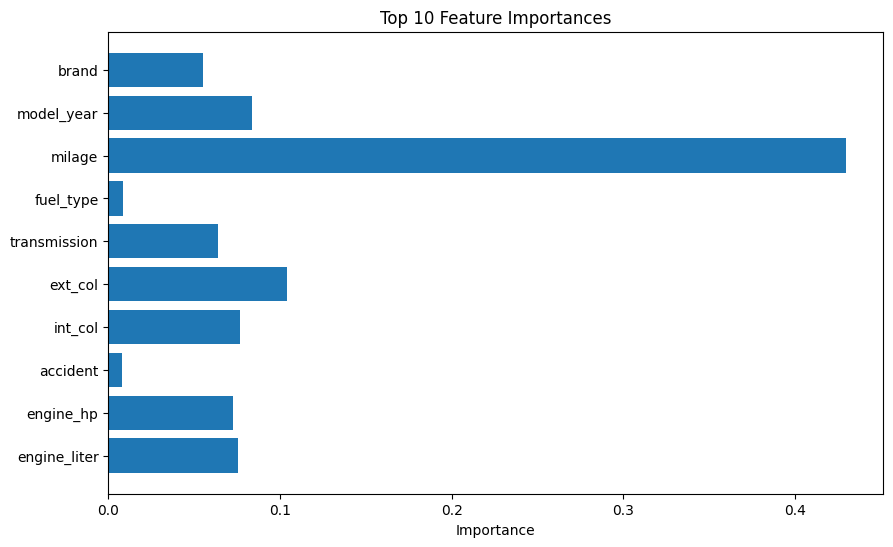

In [22]:
import matplotlib.pyplot as plt

importances = rf_model.feature_importances_
features = X.columns

# Plot top 10
plt.figure(figsize=(10, 6))
plt.barh(features[:10], importances[:10])
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances")
plt.gca().invert_yaxis()
plt.show()
